In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools as it

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 

Using TensorFlow backend.


In [2]:
(x_train0, y_train0), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train0[:50000]
y_train = y_train0[:50000]
x_hold = x_train0[50000:]
y_hold = y_train0[50000:]

In [4]:
x_train_flat = np.array([x.reshape((784)) for x in x_train])
x_test_flat = np.array([x.reshape((784))for x in x_test])
x_train_flat.shape

#"Unrolled" MNIST array is numbered left to right, top to bottom., so first entry of each unrolled vector is top-left pixel

(50000, 784)

In [5]:
def GF00(j):
    return(np.exp(-(np.floor(j/28)-13.5)**2-(j%28 - 13.5)**2))

#Handle r=0 case specially

In [6]:
GF = np.zeros((321,784))

GF[0,] = [GF00(x) for x in np.arange(784)] 
for i in range(1,32*10+1):
    for j in range(784):
        r = 1.3*(np.floor((i-1)/32)+1)
        t = (i-1)%32*(2*np.pi/32)
        u = 27-np.floor(j/28)
        v = j%28
        GF[i,j] = np.exp((-(v-13.5-r*math.cos(t))**2-(u-13.5-r*math.sin(t))**2)/(2*(.01*r+.5)))

In [7]:
x_train_rot_nonorm = np.transpose(np.matmul(GF, np.transpose(x_train_flat)))
x_test_rot_nonorm = np.transpose(np.matmul(GF, np.transpose(x_test_flat)))
x_train_rot_nonorm.shape

#Now normalize each image by dividing image values by max pixel intensity. 

x_train_rot = np.transpose(np.transpose(x_train_rot_nonorm)/np.amax(x_train_rot_nonorm,axis=1))
x_test_rot = np.transpose(np.transpose(x_test_rot_nonorm)/np.amax(x_test_rot_nonorm,axis=1))

In [8]:
#Check normalization works
print(max(x_test_rot[55]), max(x_train_rot[66]))

1.0 1.0


In [9]:
def rot_plot(image):
    dum = np.array(range(320))
    rad = 1.3*(np.floor(dum/32)+1)
    theta = (dum)%32*(2*np.pi/32)
    x_coord = np.concatenate(([0],np.multiply(rad,np.cos(theta))))
    y_coord = np.concatenate(([0],np.multiply(rad, np.sin(theta))))
    
    plt.figure(figsize=(5,5))
    plt.scatter(x = x_coord, y = y_coord, c = image,cmap="Greys")
    plt.show()

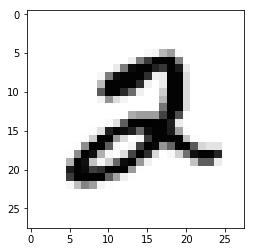

In [10]:
plt.imshow(x_train[5], cmap='Greys')

Number is 2


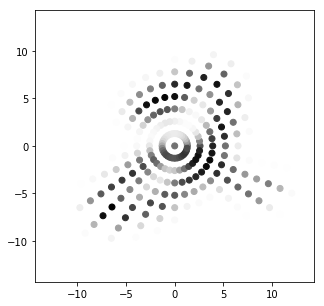

In [11]:
print("Number is",y_train[5])
rot_plot(x_train_rot[5])

In [12]:
# def firstdeg(x_train_rot):
#     dummy = np.empty(11)
    
#     dummy[0] = x_train_rot[0]
#     for i in range(10):
#         dummy[i+1] = np.sum(x_train_rot[(32*i+1):(32*i+33)])/32 #32*i+1 selects the radius
#     return(dummy)
# #FRANK!!! REMEMBER INDEXING [1:3] ONLY SELECTS ENTRIES 1 AND 2!!!

In [13]:
def firstdeg_mat(x_train_rot):
    
    dummy = x_train_rot[:,0]
    for i in range(10):
        dummy = np.column_stack((dummy,np.sum(x_train_rot[:,(32*i+1):(32*i+33)],axis=1)/32)) #32*i+1 selects the radius
    return(dummy)

In [14]:
# def secdeg(x_train_rot):
#     dummy = [x_train_rot[0]**2]
    
#     #Here calculate the terms involving center point
#     for r in range(10):
#         dummy.append(np.sum(x_train_rot[0]*x_train_rot[(r*32+1):(r*32+33)])/32)
        
#     #Then, calculate everything else
#     for i in range(10):
#         for j in range(10):
#             for k in range(17):
#                 if k == 0 and i<j: #don't double count these special pairs
#                     continue
                    
#                 total = 0
                
#                 for s in range(32):
#                     total += x_train_rot[i*32+1+s]*x_train_rot[j*32+1+(k+s)%32]
                    
#                 dummy.append(total/32)
    
#     return(np.array(dummy))

In [15]:
def secdeg_mat(x_train_rot): 
    dummy = x_train_rot[:,0]**2
    
    for r in range(10):
        dummy = np.column_stack((dummy,
                np.sum(x_train_rot[:,(r*32+1):(r*32+33)]*(x_train_rot[:,0])[:,np.newaxis],axis=1)/32))
        
    #Then, calculate everything else
    for i in range(10):
        for j in range(10):
            for k in range(9):
                if k == 0 and i<j: #don't double count these special pairs
                    continue 
                    
                total = np.zeros(x_train_rot.shape[0])

                for s in range(32):
                    total = total+x_train_rot[:,(i*32+1+s)]*x_train_rot[:,(j*32+1+(k+s)%32)]
                    
                dummy = np.column_stack((dummy,total/32))
    
    return(np.array(dummy))

In [16]:
# def thirdeg_mat(x_train_rot):
#     #Only calculate triangles with vertices on same radius, angles.
#     #Fixing the minimal angle, there is a bijection (?):
#     dummy = np.empty((x_train_rot.shape[0],0))
#     for r in range(10):
#         for i in range(1,6):
#             for j in range(16):
#                 if j < i or j > (16 - 2*i):
#                     continue
#                 total = np.zeros(x_train_rot.shape[0])
#                 for s in range(32):
#                     total = total+ x_train_rot[:,(32*r+1+s)]*x_train_rot[:,(32*r+1+(2*i+s)%32)]*x_train_rot[:,(32*r+1+(2*(i+j)+s)%32)]
                
#                 dummy = np.column_stack((dummy,total/32))
                
#     return(np.array(dummy))

In [17]:
# def rot_features(x_train_rot):
#     return(np.concatenate([firstdeg(x_train_rot),secdeg(x_train_rot),thirdeg(x_train_rot)]))
# def rot_features(x_train_rot):
#     return(np.column_stack((firstdeg_mat(x_train_rot),secdeg_mat(x_train_rot),thirdeg_mat(x_train_rot))))
def rot_features(x_train_rot):
    return(np.column_stack((firstdeg_mat(x_train_rot),secdeg_mat(x_train_rot))))

In [18]:
x_train_features = rot_features(x_train_rot)
x_test_features = rot_features(x_test_rot)

In [19]:
model = keras.Sequential([
    #keras.layers.Dropout(.3,input_shape = (x_train_features.shape[1],), noise_shape=None, seed=None),
    keras.layers.Dense(200, input_shape = (x_train_features.shape[1],), activation=tf.nn.relu),
    #keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    keras.layers.Dense(100, activation = tf.nn.relu),
    #keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
model.fit(x_train_features, y_train, verbose=1, epochs=15)

Epoch 1/15
50000/50000 [==============================] - 8s 160us/sample - loss: 0.6673 - acc: 0.7924
Epoch 2/15
50000/50000 [==============================] - 7s 149us/sample - loss: 0.3656 - acc: 0.8878
Epoch 3/15
50000/50000 [==============================] - 7s 149us/sample - loss: 0.2958 - acc: 0.9076
Epoch 4/15
50000/50000 [==============================] - 7s 147us/sample - loss: 0.2561 - acc: 0.9191
Epoch 5/15
50000/50000 [==============================] - 7s 148us/sample - loss: 0.2330 - acc: 0.9265
Epoch 6/15
50000/50000 [==============================] - 7s 148us/sample - loss: 0.2136 - acc: 0.9325
Epoch 7/15
50000/50000 [==============================] - 7s 150us/sample - loss: 0.1961 - acc: 0.9386
Epoch 8/15
50000/50000 [==============================] - 7s 148us/sample - loss: 0.1881 - acc: 0.9398
Epoch 9/15
50000/50000 [==============================] - 7s 148us/sample - loss: 0.1778 - acc: 0.9425
Epoch 10/15
50000/50000 [==============================] - 7s 149us/sampl

In [21]:
model.evaluate(x_test_features, y_test)

10000/10000 [==============================] - 1s 72us/sample - loss: 0.1615 - acc: 0.9503


[0.1614843192189932, 0.9503]

In [22]:
# #Looking at predictions made by trained model
#predictions1 = np.argmax(model.predict(x_test_features),axis=1)
# predictions = np.column_stack((predictions1,y_test))
# print(predictions[1:10,])

In [23]:
# #Now, we look at a model that considers up to second order features:

# x_train_secorder = x_train_features[:,0:611]
# x_test_secorder = x_test_features[:,0:611]

# model_secorder = keras.Sequential([
#     keras.layers.Dense(200, input_shape = (611,), activation=tf.nn.relu),
#     keras.layers.Dense(10, activation=tf.nn.softmax)
# ])

# model_secorder.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model_secorder.fit(x_train_secorder, y_train, epochs=30)

In [24]:
# model_secorder.evaluate(x_test_secorder, y_test)

In [25]:
#Now want to show features are invariant under rotation (technically by 2pi/32)
#Creating the rotation matrix
PermBlock = np.empty((32,32))
for i in range(32):
    for j in range(32):
        if (i+1)%32 == j:
            PermBlock[i,j] = 1
        else:
            PermBlock[i,j] = 0
            
PermMat1 = np.kron(np.eye(10),PermBlock)
PermMat2 = np.vstack((np.zeros((1,320)),PermMat1))
PermMat_FirstCol = np.zeros((321,1))
PermMat_FirstCol[0] = 1
PermMat = np.hstack((PermMat_FirstCol,PermMat2))
print(PermMat.shape)
PermMat

(321, 321)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
#Show that features are invariant under rotation by 2*pi/32. Will do it on test set, since calculating features is long.
#As this generates group, features invariant under entire action
rotated1 = rot_features(np.transpose(np.matmul(PermMat,np.transpose(x_test_rot))))
np.amax(np.abs(x_test_features-rotated1))

4.440892098500626e-16

In [27]:
#Confirm for an even more extreme rotation of 13*2*pi/32.
rotated2 = rot_features(np.transpose(np.matmul(np.linalg.matrix_power(PermMat,13),np.transpose(x_test_rot))))
np.amax(np.abs(x_test_features-rotated2))

7.771561172376096e-16

In [28]:
#Finally, let's look at predictions by the NN:
predictions1 = np.argmax(model.predict(x_test_features),axis=1)
predictions_rot = predictions1 = np.argmax(model.predict(rotated2),axis=1)
np.argmax(np.abs(predictions1 - predictions_rot))

0

In [29]:
# print(y_train[0])
# rot_plot(np.matmul(np.linalg.matrix_power(PermMat,8),x_train_rot[0]))

In [30]:
#Now want to train a CNN:

#First, prepare the data for CNN
x_test_CNN = x_test.reshape(10000,28,28,1)
x_train_CNN = x_train.reshape(50000,28,28,1)
x_hold_CNN = x_hold.reshape(10000,28,28,1)
x_test_CNN = x_test_CNN.astype('float32')
x_train_CNN = x_train_CNN.astype('float32')
x_hold_CNN = x_hold_CNN.astype('float32')
x_test_CNN = x_test_CNN/255
x_train_CNN = x_train_CNN/255
x_hold_CNN = x_hold_CNN/255

In [31]:
# # Three steps to create a CNN
# # 1. Convolution
# # 2. Activation
# # 3. Pooling
# # Repeat Steps 1,2,3 for adding more hidden layers

# # 4. After that make a fully connected network
# # This fully connected network gives ability to the CNN
# # to classify the samples

# model_CNN = Sequential()

# model_CNN.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
# model_CNN.add(BatchNormalization(axis=-1))
# model_CNN.add(Activation('relu'))
# model_CNN.add(Conv2D(32, (3, 3)))
# model_CNN.add(BatchNormalization(axis=-1))
# model_CNN.add(Activation('relu'))
# model_CNN.add(MaxPooling2D(pool_size=(2,2)))

# model_CNN.add(Conv2D(64,(3, 3)))
# model_CNN.add(BatchNormalization(axis=-1))
# model_CNN.add(Activation('relu'))
# model_CNN.add(Conv2D(64, (3, 3)))
# model_CNN.add(BatchNormalization(axis=-1))
# model_CNN.add(Activation('relu'))
# model_CNN.add(MaxPooling2D(pool_size=(2,2)))

# model_CNN.add(Flatten())

# # Fully connected layer
# model_CNN.add(Dense(512))
# model_CNN.add(BatchNormalization())
# model_CNN.add(Activation('relu'))
# model_CNN.add(Dropout(0.2))
# model_CNN.add(Dense(10))

# model_CNN.add(Activation('softmax'))

# model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [32]:
# model_CNN.fit(x_train_CNN, y_train, epochs=5)

In [33]:
# model_CNN.evaluate(x_test_CNN, y_test)

In [34]:
#Now, generate the rotated hold out set for testing all models.

#Generate for CNN first since rotation function works for data with that shape:
x_hold_rotCNN = []

for i in range(10000):
    x_hold_rotCNN.append((tf.contrib.keras.preprocessing.image.random_rotation(x_hold_CNN[i], rg = 360, row_axis=0, col_axis=1, channel_axis=2)))

x_hold_rotCNN = np.array(x_hold_rotCNN)

#Generate features for invar features:

x_hold_rot_raw = x_hold_rotCNN.reshape(10000,28,28)
x_hold_rot_raw = np.array([x.reshape((784))for x in x_hold_rot_raw])
x_hold_rot_raw = np.transpose(np.matmul(GF, np.transpose(x_hold_rot_raw)))
x_hold_rot_raw = np.transpose(np.transpose(x_hold_rot_raw)/np.amax(x_hold_rot_raw,axis=1))
x_hold_rot_features = rot_features(x_hold_rot_raw)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [35]:
x_hold_rot_features = rot_features(x_hold_rot_raw)

In [36]:
#Generate shifted dataset for training invar:
x_train_shiftCNN = []

for i in range(50000):
    x_train_shiftCNN.append(tf.contrib.keras.preprocessing.image.random_shift(x_train_CNN[i], 0.14, 0.14, row_axis=0, col_axis=1, channel_axis=2))

x_train_shiftCNN = np.array(x_train_shiftCNN)
x_train_shift = x_train_shiftCNN.reshape(50000,28,28)
x_train_shift = np.array([x.reshape((784)) for x in x_train_shift])
x_train_shift = np.transpose(np.matmul(GF, np.transpose(x_train_shift)))
x_train_shift = np.transpose(np.transpose(x_train_shift)/np.amax(x_train_shift,axis=1))
x_train_shift_features = rot_features(x_train_shift)

In [37]:
x_train_shift_features = rot_features(x_train_shift)

In [38]:
#Finally, generate rotated dataset for CNN:

x_train_rotCNN = []

for i in range(50000):
    x_train_rotCNN.append((tf.contrib.keras.preprocessing.image.random_rotation(x_train_CNN[i], rg = 360, row_axis=0, col_axis=1, channel_axis=2)))

x_train_rotCNN = np.array(x_train_rotCNN)

#Also create split data set for other CNN:

x_train_CNNaug2 = np.concatenate((x_train_CNN[0:25000],x_train_rotCNN[25000:]),axis=0)

7


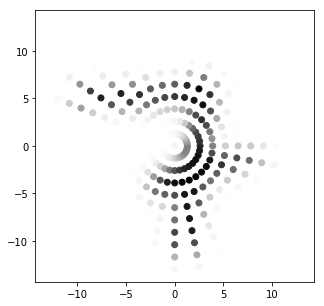

In [39]:
print(y_hold[100])
rot_plot(x_hold_rot_raw[100])

In [40]:
# model_shift2 = Sequential()

# model_shift2.add(Dense(200, input_shape = (x_train_shift_features.shape[1],)))
# model_shift2.add(Activation('relu'))
# #model_shift2.add(BatchNormalization())
# model_shift2.add(Dense(100))
# model_shift2.add(Activation('relu'))
# #model_shift2.add(BatchNormalization())
# #model_shift2.add(Dense(200))
# #model_shift2.add(Activation('relu'))
# #model_shift2.add(BatchNormalization())
# #model_shift2.add(Dropout(0.2))
# model_shift2.add(Dense(10))
# model_shift2.add(Activation('softmax'))

# model_shift2.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [41]:
#model_shift2.fit(x_train_shift_features, y_train, verbose=1, epochs=30) 

In [42]:
#model_shift2.evaluate(x_test_features, y_test)

In [43]:
model_shift = Sequential()

model_shift.add(Dense(200, input_shape = (x_train_shift_features.shape[1],)))
model_shift.add(Activation('relu'))
#model_shift.add(BatchNormalization())
model_shift.add(Dense(200))
model_shift.add(Activation('relu'))
#model_shift.add(BatchNormalization())
#model_shift.add(Dense(200))
#model_shift.add(Activation('relu'))
#model_shift.add(BatchNormalization())
#model_shift.add(Dropout(0.2))
model_shift.add(Dense(10))
model_shift.add(Activation('softmax'))

model_shift.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model_shift.fit(x_train_shift_features, y_train, verbose=1, epochs=60) 
#Will have trained for 60 epochs. 5*15. While training accuracy goes up, test accuracy on unrotated hold out seems constant after ~30 epochs.

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
50000/50000 [==============================] - 8s 169us/step - loss: 1.2196 - acc: 0.5793
Epoch 2/60
50000/50000 [==============================] - 8s 150us/step - loss: 0.8144 - acc: 0.7314
Epoch 3/60
50000/50000 [==============================] - 8s 157us/step - loss: 0.6739 - acc: 0.7775
Epoch 4/60
50000/50000 [==============================] - 8s 151us/step - loss: 0.5952 - acc: 0.8029
Epoch 5/60
50000/50000 [==============================] - 7s 150us/step - loss: 0.5462 - acc: 0.8208
Epoch 6/60
50000/50000 [==============================] - 8s 150us/step - loss: 0.5107 - acc: 0.8299
Epoch 7/60
50000/50000 [==============================] - 8s 150us/step - loss: 0.4748 - acc: 0.8428
Epoch 8/60
50000/50000 [==============================] - 8s 152us/step - loss: 0.4555 - acc: 0.8483
Epoch 9/60
50000/50000 [==============================] - 7s 149us/step - loss: 0.4316 - acc: 0.8566
Epoch 10/60
50000/50000 [==================

In [45]:
model_shift.evaluate(x_test_features, y_test)

10000/10000 [==============================] - 1s 60us/step


[0.44840743787288667, 0.8837]

In [46]:
# print("Number is ",y_hold[100])
# rot_plot(x_hold_rot_raw[100])

In [47]:
# #Now try CNN on rotated data
# model_CNNaug = Sequential()

# model_CNNaug.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
# model_CNNaug.add(BatchNormalization(axis=-1))
# model_CNNaug.add(Activation('relu'))
# model_CNNaug.add(Conv2D(32, (3, 3)))
# model_CNNaug.add(BatchNormalization(axis=-1))
# model_CNNaug.add(Activation('relu'))
# model_CNNaug.add(MaxPooling2D(pool_size=(2,2)))

# model_CNNaug.add(Conv2D(64,(3, 3)))
# model_CNNaug.add(BatchNormalization(axis=-1))
# model_CNNaug.add(Activation('relu'))
# model_CNNaug.add(Conv2D(64, (3, 3)))
# model_CNNaug.add(BatchNormalization(axis=-1))
# model_CNNaug.add(Activation('relu'))
# model_CNNaug.add(MaxPooling2D(pool_size=(2,2)))

# model_CNNaug.add(Flatten())

# # Fully connected layer
# model_CNNaug.add(Dense(512))
# model_CNNaug.add(BatchNormalization())
# model_CNNaug.add(Activation('relu'))
# model_CNNaug.add(Dropout(0.2))
# model_CNNaug.add(Dense(10))

# model_CNNaug.add(Activation('softmax'))

# model_CNNaug.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [48]:
# model_CNNaug.fit(x_train_rotCNN, y_train, epochs=10)

In [49]:
# model_CNNaug.evaluate(x_test_CNN, y_test)

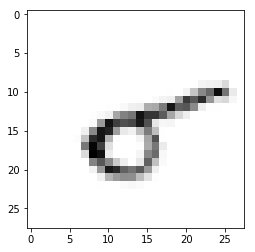

In [50]:
plt.imshow(x_train_CNNaug2[30010].reshape(28,28),cmap='Greys')

In [51]:
#Now try CNN on augmented data: half origin
model_CNNaug2 = Sequential()

model_CNNaug2.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model_CNNaug2.add(BatchNormalization(axis=-1))
model_CNNaug2.add(Activation('relu'))
model_CNNaug2.add(Conv2D(32, (3, 3)))
model_CNNaug2.add(BatchNormalization(axis=-1))
model_CNNaug2.add(Activation('relu'))
model_CNNaug2.add(MaxPooling2D(pool_size=(2,2)))

model_CNNaug2.add(Conv2D(64,(3, 3)))
model_CNNaug2.add(BatchNormalization(axis=-1))
model_CNNaug2.add(Activation('relu'))
model_CNNaug2.add(Conv2D(64, (3, 3)))
model_CNNaug2.add(BatchNormalization(axis=-1))
model_CNNaug2.add(Activation('relu'))
model_CNNaug2.add(MaxPooling2D(pool_size=(2,2)))

model_CNNaug2.add(Flatten())

# Fully connected layer
model_CNNaug2.add(Dense(512))
model_CNNaug2.add(BatchNormalization())
model_CNNaug2.add(Activation('relu'))
model_CNNaug2.add(Dropout(0.2))
model_CNNaug2.add(Dense(10))

model_CNNaug2.add(Activation('softmax'))

model_CNNaug2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model_CNNaug2.fit(x_train_rotCNN, y_train, epochs=5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [52]:
#model_CNNaug2.evaluate(x_test_CNN, y_test)

In [53]:
x_train_shift_features_sub = x_train_shift_features[(y_train != 9) & (y_train != 2)]
y_train_sub = y_train[(y_train != 9) & (y_train != 2)]
x_hold_rot_features_sub = x_hold_rot_features[(y_hold != 9) & (y_hold != 2)]
y_hold_sub = y_hold[(y_hold != 9) & (y_hold != 2)]
x_test_features_sub = x_test_features[(y_test != 9) & (y_test != 2)]
y_test_sub = y_test[(y_test != 9) & (y_test != 2)]

In [54]:
model_shift_sub = Sequential()

model_shift_sub.add(Dense(250, input_shape = (x_train_shift_features.shape[1],)))
model_shift_sub.add(Activation('relu'))
#model_shift_sub.add(BatchNormalization())
model_shift_sub.add(Dense(100))
model_shift_sub.add(Activation('relu'))
#model_shift_sub.add(BatchNormalization())
model_shift_sub.add(Dense(200))
model_shift_sub.add(Activation('relu'))
#model_shift_sub.add(BatchNormalization())
model_shift_sub.add(Dropout(0.2))
model_shift_sub.add(Dense(10))
model_shift_sub.add(Activation('softmax'))

model_shift_sub.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
model_shift_sub.fit(x_train_shift_features_sub, y_train_sub, verbose=1, epochs=60) 

Epoch 1/60
40044/40044 [==============================] - 9s 234us/step - loss: 1.0236 - acc: 0.6288
Epoch 2/60
40044/40044 [==============================] - 8s 201us/step - loss: 0.6328 - acc: 0.7864
Epoch 3/60
40044/40044 [==============================] - 8s 196us/step - loss: 0.5201 - acc: 0.8273
Epoch 4/60
40044/40044 [==============================] - 8s 198us/step - loss: 0.4539 - acc: 0.8489
Epoch 5/60
40044/40044 [==============================] - 8s 195us/step - loss: 0.4120 - acc: 0.8630
Epoch 6/60
40044/40044 [==============================] - 8s 198us/step - loss: 0.3754 - acc: 0.8746
Epoch 7/60
40044/40044 [==============================] - 8s 198us/step - loss: 0.3478 - acc: 0.8854
Epoch 8/60
40044/40044 [==============================] - 8s 197us/step - loss: 0.3322 - acc: 0.8919
Epoch 9/60
40044/40044 [==============================] - 8s 196us/step - loss: 0.3081 - acc: 0.8971
Epoch 10/60
40044/40044 [==============================] - 8s 196us/step - loss: 0.2992 - a

In [59]:
print("InvarFeatures, Sec: ",model.evaluate(x_hold_rot_features, y_hold))
print("InvarShift, Sec :", model_shift.evaluate(x_hold_rot_features, y_hold))
print("InvarShift, Sec, no 9 or 2 :", model_shift_sub.evaluate(x_hold_rot_features_sub, y_hold_sub))
#print("CNN: ",model_CNN.evaluate(x_hold_rotCNN, y_hold))
#print("CNNaug: ",model_CNNaug.evaluate(x_hold_rotCNN, y_hold))
# print("CNNaug2: ", model_CNNaug2.evaluate(x_hold_rotCNN, y_hold))

10000/10000 [==============================] - 0s 49us/sample - loss: 1.9642 - acc: 0.6414
InvarFeatures, Sec:  [1.9642355554580688, 0.6414]
10000/10000 [==============================] - 0s 45us/step
InvarShift, Sec : [0.37378324638456106, 0.9024]
8049/8049 [==============================] - 0s 54us/step
InvarShift, Sec, no 9 or 2 : [0.24529866085445967, 0.9399925456726561]


In [58]:
# predictions = np.array(np.argmax(model.predict(x_test_features),axis=1))
# predictions = np.column_stack((predictions,np.array(np.argmax(model.predict(x_test_rotated_features),axis=1))))
# predictions = np.column_stack((predictions,y_test))